In [1]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [224]:
prefix='sockperf-eval'
prefix='res2'

In [225]:
res_dir = os.listdir(f'../{prefix}')[0]
res_dir = f"{prefix}/{res_dir}"

In [240]:
def import_pidstat(res_dir):
    pidstat = pd.read_csv(f"../{res_dir}/summary/server/cpu-pidstat.csv")
    tmp = pidstat.groupby(['cpu', 'client', 'core', 'timestamp', 'run']).sum(numeric_only=True).reset_index() 
    tmp = tmp.groupby(['cpu', 'client', 'core', 'run']).median(numeric_only=True).reset_index()
    tmp = tmp.groupby(['cpu', 'client', 'core']).max(numeric_only=True).reset_index()
    global_cpu = tmp.groupby(['cpu', 'client']).mean().reset_index()
    return global_cpu, tmp

def import_cpu(res_dir):
    cpu = pd.read_csv(f"../{res_dir}/summary/server/cpu-sar.csv")
    cpu = cpu[cpu.core != -1]
    tmp = cpu.groupby(['cpu', 'client', 'core', 'run']).median().reset_index()
    tmp = cpu.groupby(['cpu', 'client', 'core']).max().reset_index()
    tmp['used'] = 100 - tmp['idle']
    global_cpu = tmp.groupby(['cpu', 'client']).mean().reset_index()
    return global_cpu, tmp

def import_latency(res_dir):
    latency = pd.read_csv(f"../{res_dir}/summary/clients/sockperf-1.csv")
    tails = ['99th', '99.9th', '99.99th', '99.999th',]
    cols = ['min', 'median', 'max'] + tails
    latency = latency.groupby(['cpu', 'client', 'run']).median().reset_index()
    latency = latency.groupby(['cpu', 'client']).max().reset_index()
    latency[cols] /= 1000
    return latency

def import_throughput(res_dir):
    net = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")
    net = net[net.iface == 'wg']
    net = net.groupby(['cpu', 'client', 'run']).median(numeric_only=True).reset_index()
    net = net.groupby(['cpu', 'client',]).max(numeric_only=True).reset_index()
    net['rxkB/s'] = net['rxkB/s'] * 8 / 1e6
    net['txkB/s'] = net['txkB/s'] * 8 / 1e6
    return net

def plot_all(res_dirs, importer, kind='bar', y='used', ylabel='CPU Usage (in %)', ylim=None):
    vanilla = importer(res_dirs[0][0])
    cryptonce = importer(res_dirs[1][0])

    df = pd.DataFrame()
    df['client'] = vanilla['client']
    df['VANILLA'] = vanilla[y]
    df['CRYPTONCE'] = cryptonce[y]

    if kind == 'bar':
        df.plot.bar(x='client', y=['VANILLA', 'CRYPTONCE'], color=['black', 'red'],
               grid=True, ylabel=ylabel, ylim=ylim)
        plt.xticks(rotation=0)
    elif kind == 'line':
        ax = vanilla.plot(
            x='client', y=y, grid=True, color='black', marker='x',
            label='VANILLA', xlabel='Clients', ylabel=ylabel,
        )
        ax = cryptonce.plot(ax=ax, marker='o',
            x='client', y=y, grid=True, color='red',
            label='CRYPTONCE', xlabel='Clients', ylabel=ylabel, ylim=ylim
        )
    plt.show()

In [241]:
def reslv_res_name(res_dir):
    filename = f"../{res_dir}/EXPERIMENT_DATA/TEST_CONFIG"    
    with open(filename) as file:
        test_config = file.read().strip()
    
    yaml_file = f"../{res_dir}/EXPERIMENT_DATA/{test_config}.yaml"
    with open(yaml_file) as file:
        content = yaml.load(file, yaml.FullLoader)
        flow = content['all']['vars']['bandwidth']
    
    if test_config != 'default':
        use_case, suffix = test_config.split('--')
        crypted = suffix.split('-')[0]
        threaded = "-".join(suffix.split('-')[1:])
#         threaded = len(suffix.split('-')[1:]) == 2
    else:
        use_case = wg_variant = traffic = flow = None
        
    return test_config, use_case, flow, crypted, threaded

In [242]:
res_dirs = [(f"{prefix}/{e}", *reslv_res_name(f"{prefix}/{e}")) 
            for e in os.listdir(f"../{prefix}") if e.startswith("results-")]

In [243]:
# 1. find yes and put it at start
# 2. find no and put it at second

def find_index(res_dirs, val):
    for k, res in enumerate(res_dirs):
        if res[4] == val:
            return k

In [244]:
prefix='res2'
try:
    os.makedirs(f"../graphs/{prefix}")
except:
    pass
res_dirs = [(f"{prefix}/{e}", *reslv_res_name(f"{prefix}/{e}")) 
            for e in os.listdir(f"../{prefix}") if e.startswith("results-")]
index = find_index(res_dirs, 'yes')
yes = res_dirs.pop(index)
res_dirs.insert(0, yes)

In [245]:
def pidstat_importer(res_dir):
    return import_pidstat(res_dir)[0]

def cpu_importer(res_dir):
    return import_cpu(res_dir)[0]

In [246]:
names = {
    'yes': 'VANILLA',
    'partial': 'CRYPTONCE',
}

In [247]:
res_dirs

[('res2/results-841258a9',
  'upload--yes-kernel-v1',
  'upload',
  '150Mbits',
  'yes',
  'kernel-v1'),
 ('res2/results-736b682b',
  'upload--partial-kernel-v1',
  'upload',
  '150Mbits',
  'partial',
  'kernel-v1')]

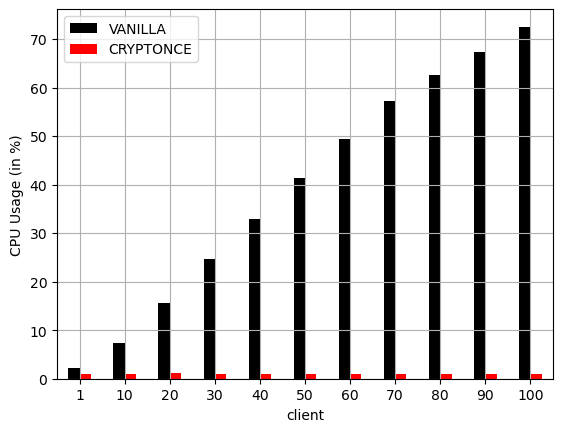

In [248]:
plot_all(res_dirs, pidstat_importer)

In [249]:
plot_all(res_dirs, import_latency, y='99.99th', ylim=[0,20], ylabel='99.99th Tail Latency (in us)')

TypeError: agg function failed [how->median,dtype->object]

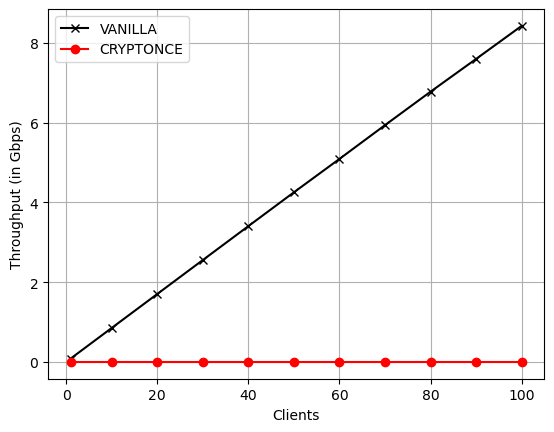

In [250]:
plot_all(res_dirs, import_throughput,  kind='line', y='rxkB/s', ylabel='Throughput (in Gbps)')

In [251]:
res_dirs

[('res2/results-841258a9',
  'upload--yes-kernel-v1',
  'upload',
  '150Mbits',
  'yes',
  'kernel-v1'),
 ('res2/results-736b682b',
  'upload--partial-kernel-v1',
  'upload',
  '150Mbits',
  'partial',
  'kernel-v1')]